# Geocoding API


In [15]:
import herepy
import pandas as pd
from tqdm import tqdm 
import time
import math

geocoderApi = herepy.GeocoderApi('ZJD1l_bw7yOZjJ9nDXoCNCVv5d-9nute2h9mcsgWsxE')
geocoderReverseApi = herepy.GeocoderReverseApi('ZJD1l_bw7yOZjJ9nDXoCNCVv5d-9nute2h9mcsgWsxE')

## Tuguegarao

In [5]:
df = pd.read_csv('Mago_copy_Cavolun_initiative.csv')

In [6]:
df = df[(df['USABLE ADDRESS'] == 'Yes') | (df['REVISED ADDRESS'].notnull())]

## GeoCoder

The process of converting an address to a specific coordinate

In [19]:
response = geocoderApi.free_form('Diosdado Macapagal Avenue, Balzain East Tuguegarao City , Centro, Cagayan')

In [20]:
response.as_dict()
# pd.DataFrame(response.as_dict()['items']).head(1)['position'][0]['lng']

{'items': [{'title': 'Macapagal Ave, 3500 Tuguegarao City, Philippines',
   'id': 'here:af:streetsection:2dcww25f64WnogFQPMfaiB',
   'resultType': 'street',
   'address': {'label': 'Macapagal Ave, 3500 Tuguegarao City, Philippines',
    'countryCode': 'PHL',
    'countryName': 'Philippines',
    'state': 'Cagayan Valley',
    'county': 'Cagayan',
    'city': 'Tuguegarao City',
    'district': 'Centro 11 Pob.',
    'street': 'Macapagal Ave',
    'postalCode': '3500'},
   'position': {'lat': 17.6191, 'lng': 121.73448},
   'mapView': {'west': 121.73321,
    'south': 17.61449,
    'east': 121.73495,
    'north': 17.62557},
   'scoring': {'queryScore': 0.66,
    'fieldScore': {'county': 1.0,
     'city': 1.0,
     'district': 0.36,
     'streets': [1.0]}}}]}

In [7]:
df = df.reset_index(drop = True)

In [12]:
df['AREA'] = df['AREA'].replace('Cetro', 'Centro')
df['AREA'] = df['AREA'].replace('before meynars papasok sa drugstore', '')

In [13]:
df['AREA'].unique()

array(['East: Namabbalan-Capatan', 'North: Carig-Caritan', 'Centro',
       'West: Buntun-Ugac', nan, 'Centro: Centro 1-12', 'Pengue',
       'Linao East', 'Linao Norte, Tuguegarao', 'Linao, Tuguegarao',
       'Buntun, Tuguegarao', 'Linao Norte', 'Linao Norte ', 'Linao West',
       'West san gabriel', 'Annafuan East', 'Enrile Cagayan',
       'linao norte', 'Buntun', 'LINAO NORTH', 'Balzain', 'Linao east',
       'Annafunan West', 'San Gabriel', 'Liano EAST tapat',
       'Balzain East Tuguegarao City', 'Gabut, Amulung ',
       'Cataggaman Nuevo', 'Cattaggamman', 'Tuguegarao City',
       'Annafunan East', 'Linao east ', 'annafunan west', 'Balzain East',
       'Linao East ', 'linao east ', 'pinakadulo ', 'Balzain west', 'Tan',
       'Linao North', 'Tanza', 'Ugac Sur', 'Pallua Sur', '',
       'balzain east ', 'West Area', 'Anao, Cabagan, Isabela',
       'Liano East ', 'Pallua Sur, near elem school papasok sa kanto ',
       'Brgy. San Gabriel', 'Tuguegarao '], dtype=object)

In [23]:
df = df[df['address'] != '']

In [25]:
lat_list = []
lng_list = []
with tqdm(total=df.shape[0]) as pbar:
    for index, row in df.iterrows():
        pbar.update(1)
                
        try:
            if pd.isnull(row['REVISED ADDRESS']):
                address = row['address']
            else:
                address = row['REVISED ADDRESS']
        except:
            address = row['REVISED ADDRESS']
            
        if pd.isnull(row['AREA']) == False:
            address = address + ', ' + row['AREA']
            
        if "tuguegarao" in address.lower():
            address = address + ', Cagayan'
        else:
            address = address + ', Tuguegarao City, Cagayan'
            
#         print(address)
                    
        response = geocoderApi.free_form(address)
        try:
            lat = pd.DataFrame(response.as_dict()['items']).head(1)['position'][0]['lat']
            long = pd.DataFrame(response.as_dict()['items']).head(1)['position'][0]['lng']
            
            lat_list.append(lat)
            lng_list.append(long)
        except:
            lat_list.append(0)
            lng_list.append(0)
        time.sleep(2)

 99%|█████████▉| 387/389 [15:29<00:04,  2.40s/it]


AttributeError: 'float' object has no attribute 'lower'

In [26]:
test = pd.concat([df,pd.Series(lat_list),pd.Series(lng_list)], ignore_index=True, axis=1)


In [29]:
df['lat'] = test[13]
df['lng'] = test[14]

In [30]:
df.to_csv('tuguegeocoded_locations_v2.csv')

## GEOPANDAS

GeoPandas is an open source project to make working with geospatial data in python easier.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

#### Converting our scraped data to geopandas format

In [2]:
df = pd.read_csv('tugue_geocoded_locations.csv')

In [31]:
# Converting the 
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'].astype(float)

In [32]:
df = df[(df['lng'] >= 121.68) & (df['lng'] <= 121.85)]
df = df[(df['lat'] >= 17.525) & (df['lat'] <= 17.7)]

In [33]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lng, df.lat))

<AxesSubplot:>

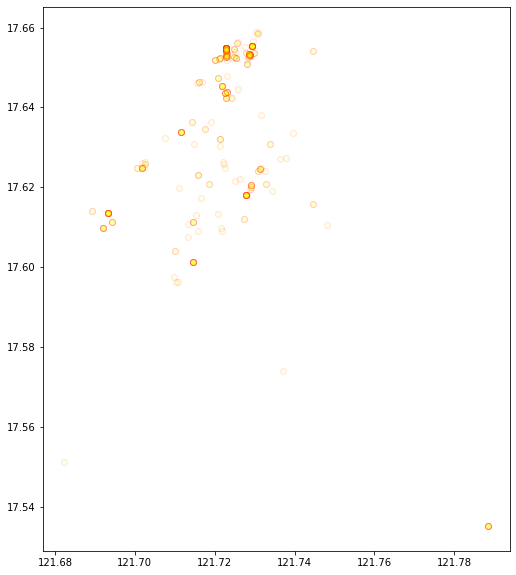

In [34]:
gdf.plot(figsize=(10, 10), alpha=0.1, color =  'yellow', edgecolor='red')

#### Reading a shp file to map out the Philippines

In [35]:
ph = gpd.read_file('ph_shp/MuniCities.shp')
ph = ph[ph['NAME_2'] == 'Tuguegarao City']

<AxesSubplot:>

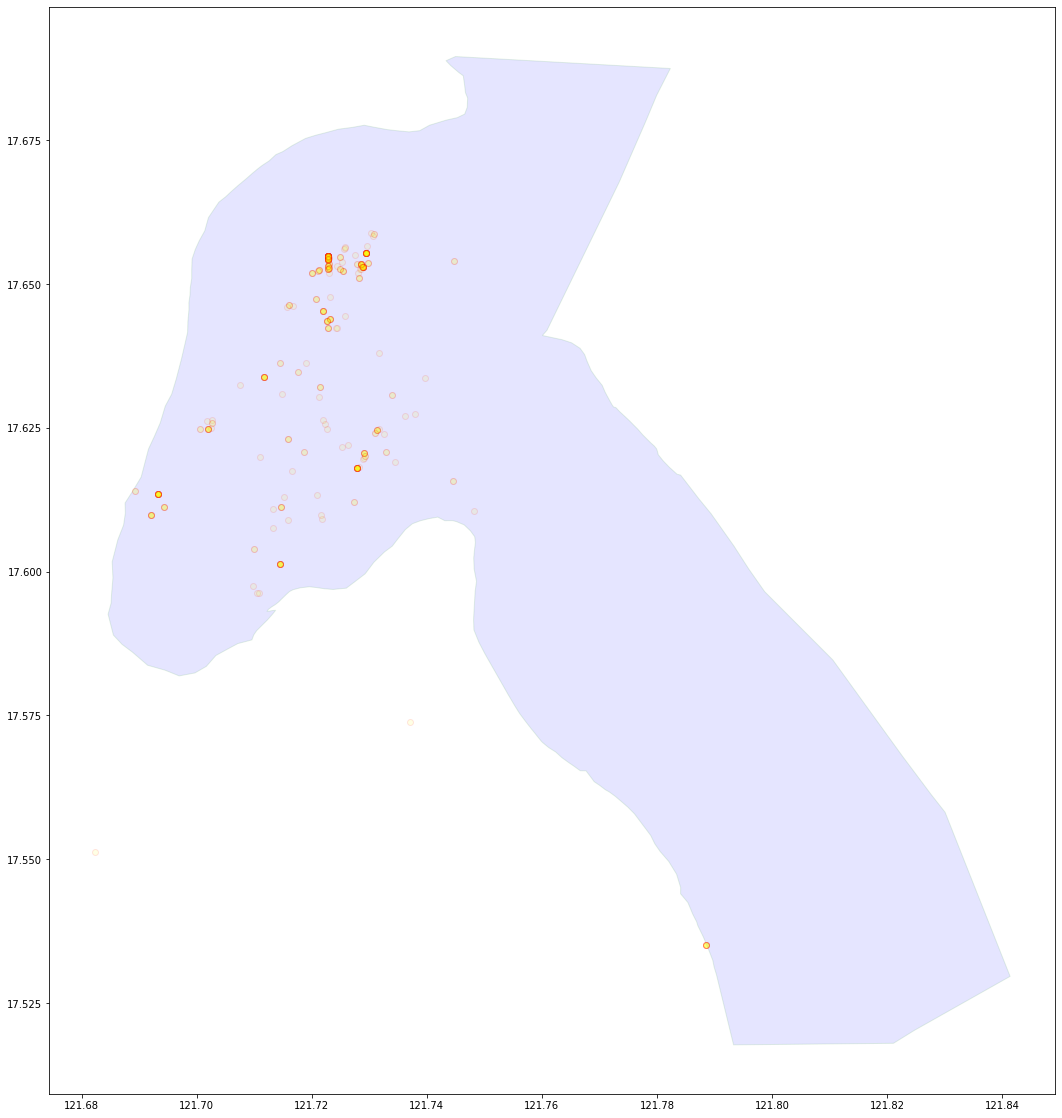

In [36]:
ax = ph.plot(figsize=(20, 20), alpha=0.1, color =  'blue', edgecolor='green')
gdf.plot(ax = ax, alpha=0.1, color =  'yellow', edgecolor='red')

## Adding More Context 

In [37]:
import contextily as ctx

In [38]:
# Convert coordinate reference system

gdf.crs = {'init' :'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

ph = ph.to_crs(epsg=3857)

C:\Anaconda\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


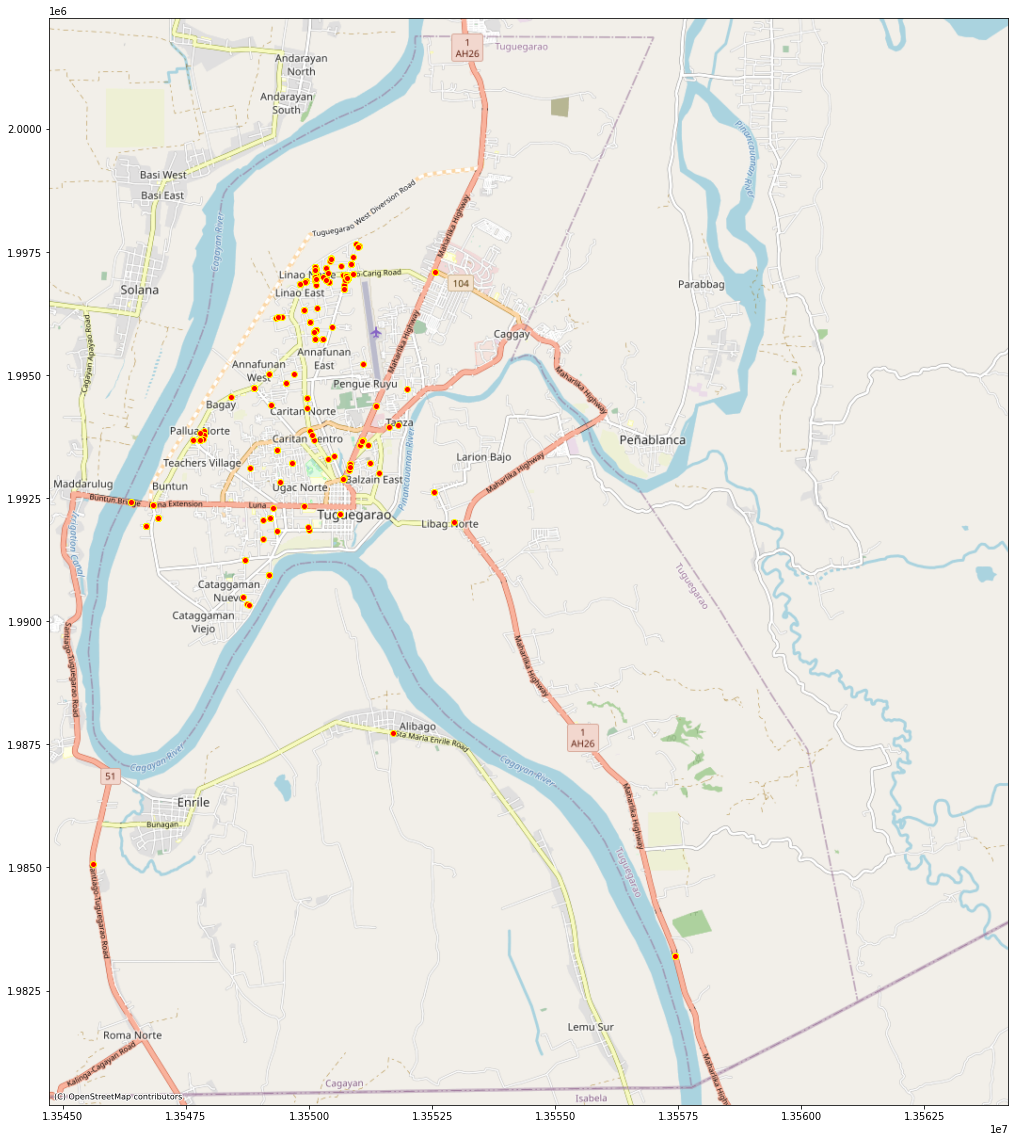

In [39]:
ax = ph.plot(figsize=(20, 20), alpha=0.0, color =  'blue', edgecolor='green')
ax = gdf.plot(ax = ax,alpha=1, color =  'red', edgecolor='yellow')
ax = ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.savefig('world.jpg')

In [266]:
!pip install folium

In [40]:
import folium

In [41]:
df['info'] = [' DETAILS: '.join(i) for i in zip(df['address'].astype(str),df['NOTES'].astype(str))]

In [42]:
df = df.reset_index(drop = True)

In [43]:
df['info'] = [' CONTACT NUMBER: '.join(i) for i in zip(df['info'].astype(str),df["Contact Number\n  ANOTHER NOTE: Countless rescuers na ang namatay dahil naelectrocute ng generators. INFORM PEOPLE SA CAGAYAN TO TURN OFF THEIR GENERATORS. Buhay muna ng rescuers bago ang kuryente!!"].astype(str))]

In [49]:
map1 = folium.Map(
    location=[17.6445371,121.7259032 ],
    tiles='cartodbpositron',
    zoom_start=12,
)
folium.TileLayer('openstreetmap').add_to(map1)
df.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lng"]], popup = row["info"],fill_color='red',fill_opacity=1).add_to(map1), axis=1)
map1

In [50]:
map1.save('tuguegarao.html')